#### I. A. J Pathirana - Reg No: 219379C

# Time Series Analysis for Apple Stock Prices (AAPL)
##### Daily data from from 2008 to 2018

In [48]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from IPython.display import Markdown, display
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

In [49]:
# Import data

df = pd.read_csv('/content/drive/MyDrive/MSc/data_science/week_5/AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-01-02,7.116786,7.152143,6.876786,6.958571,6.002815,1079178800
1,2008-01-03,6.978929,7.049643,6.881786,6.961786,6.005590,842066400
2,2008-01-04,6.837500,6.892857,6.388929,6.430357,5.547152,1455832000
3,2008-01-07,6.473214,6.557143,6.079643,6.344286,5.472903,2072193200
4,2008-01-08,6.433571,6.516429,6.100000,6.116071,5.276032,1523816000


In [50]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Lets convert **Date** column to datetime

In [51]:
df['Date'] = pd.to_datetime(df['Date'])

We will consider **Date** and **Adj Close** for our analysis

In [52]:
df_f = df[['Date', 'Adj Close']]

First, let's plot these data

Text(0, 0.5, 'Adjusted Close Price')

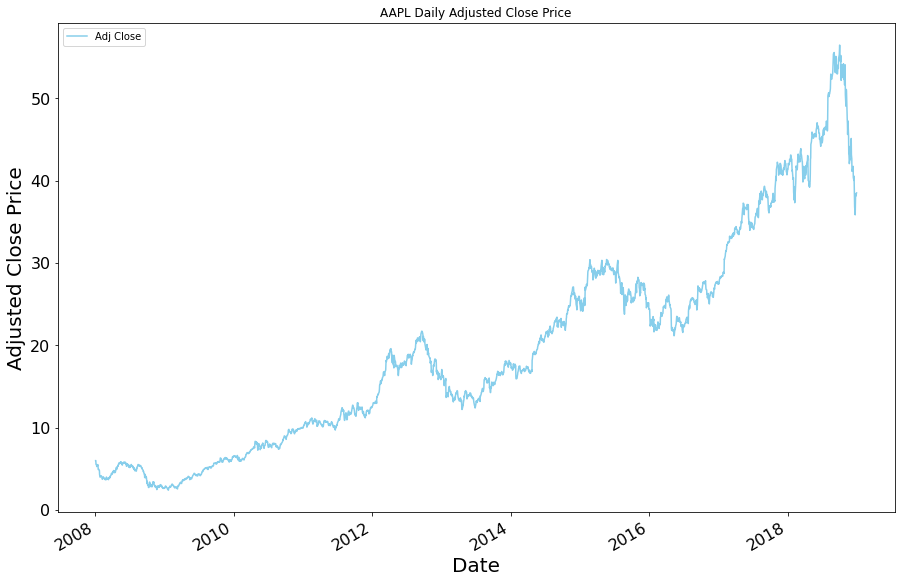

In [53]:
plt.rcParams["figure.figsize"] = (15,10)

# Plot the time series
df_f.plot('Date', 'Adj Close', color="skyblue")
plt.title('AAPL Daily Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')

## Trend

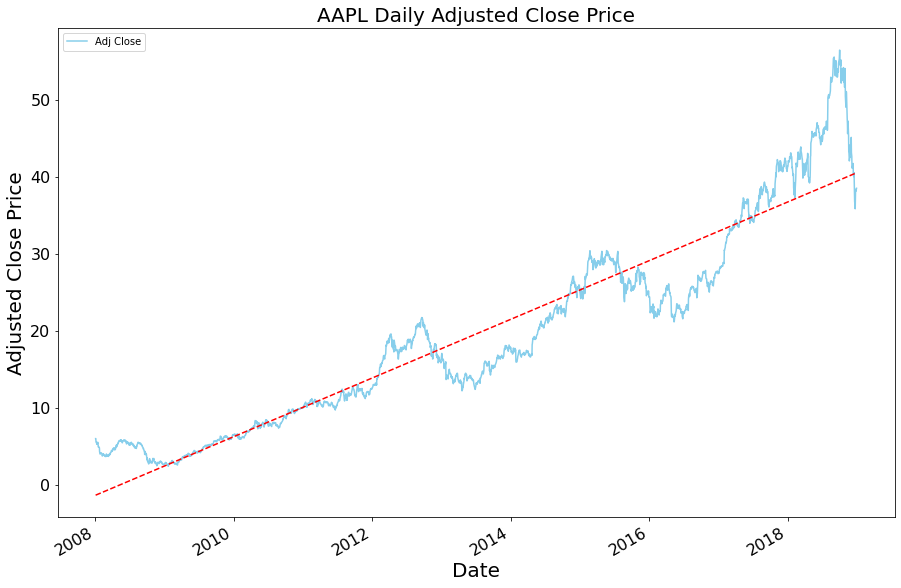

In [54]:
plt.rcParams["figure.figsize"] = (15,10)

x = mdates.date2num(df_f['Date'])
y= df_f['Adj Close']
z = np.polyfit(x, df_f['Adj Close'], 1)
p = np.poly1d(z)

# Plot the time series with the trendline
df.plot('Date', 'Adj Close', color="skyblue")
plt.title('AAPL Daily Adjusted Close Price' ,fontsize= 20)
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.plot(x, p(x), "r--")

We can see a clear upward trend. 

## TIme series components

Let's decompose this series to observe the time series components

Text(0.5, 128.43461894323337, 'Year')

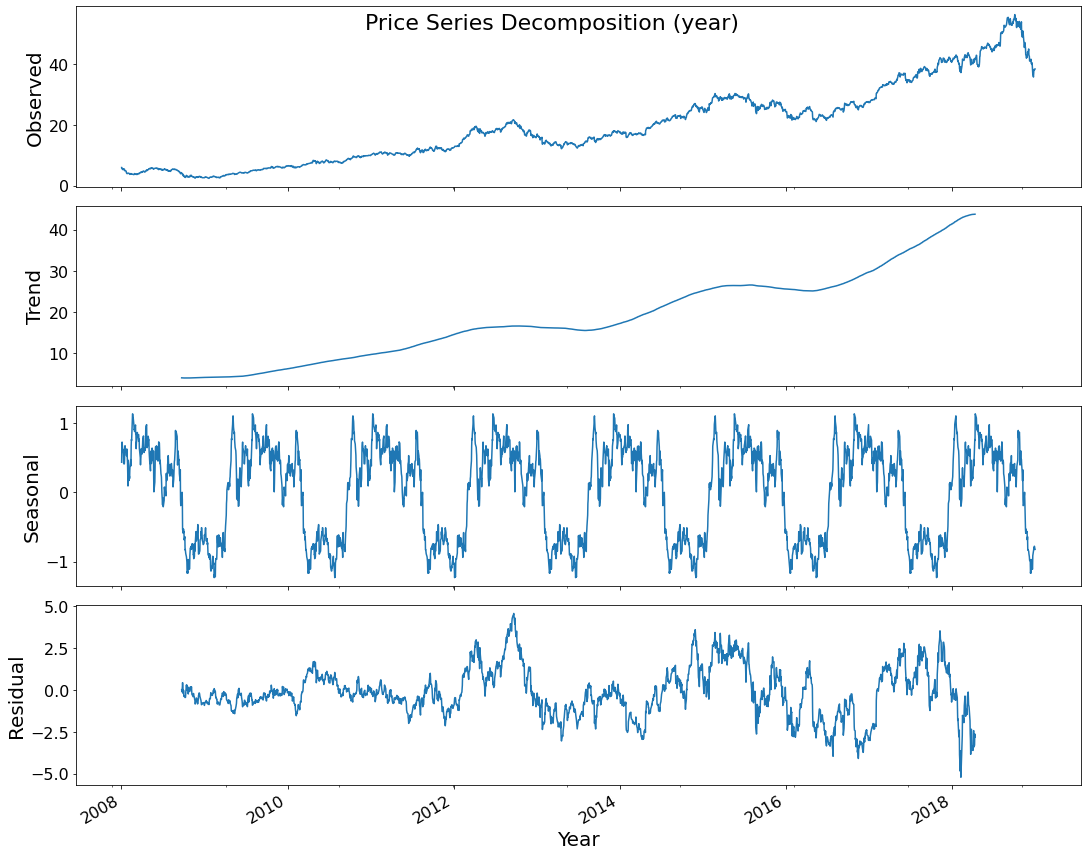

In [55]:
df_tc = df_f
df_tc = df_tc.set_index('Date')

from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
decomposition = sm.tsa.seasonal_decompose(df_tc['Adj Close'], freq = 365)
decomp = decomposition.plot()
decomp.suptitle('Price Series Decomposition (year)', fontsize=22)
plt.xlabel('Year')

Decomposition analysis shows a clear upward trend and a seasonal component.

## Transformation, Smoothing, and Differencing

In order to perform the forecasting, we need a stationary series. Since this series has both trend and seasonl components, It should be non-stationary. <br>
However we will perform stationary tests to conclusively determine the stationarity of the series

### Augmented Dickey Fuller test (ADH Test)

**Null hypothesis**: time series possesses a unit root and is non-stationary <br>
**Alternative hypothesis**: time series does not possesses a unit root and is stationary

Testing at 95% significance level

In [56]:
# ADF Test
result = adfuller(df_f['Adj Close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.9676229810340724
p-value: 0.76488919606741
Critial Values:
   1%, -3.43273884556851
Critial Values:
   5%, -2.8625954199228967
Critial Values:
   10%, -2.567331834008205


p-value > 0.05 <br>
Hence we accept the null hypothesis. **Series is non-stationary at 95% significance level.**

### Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

**Null hypothesis**: time series does not possesses a unit root and is stationary <br>
**Alternative hypothesis**: time series possesses a unit root and is non-stationary

Testing at 95% significance level

In [57]:
# KPSS Test
result = kpss(df_f['Adj Close'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 8.520002
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



p-value < 0.05 <br>
Hence we reject the null hypothesis. **Series is non-stationary at 95% significance level.**

Let's try various transformations of the series to see if we can obtain a stationary series. Here we do transformations and perform ADH test to test the stationarity.

In [58]:
#Define the plotter function
def plot_transformed_data(df, ts, ts_transform, axes):
  """
  Plot transformed and original time series data
  """
  # Plot time series data

  axes.plot(df[ts], color='dodgerblue')
  axes.plot(df[ts_transform], color='r')

  # Add title
  axes.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
  axes.tick_params(axis = 'x', rotation = 45)

  # Add legend
  axes.legend([ts, ts_transform])

Let's perform transformations and store those in the dataframe

In [59]:
df_tc=df_tc.rename(columns = {'Adj Close':'ts'})

# Transformation - log ts
df_tc['ts_log'] = df_tc['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_tc['ts_log_moving_avg'] = df_tc['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
df_tc['ts_moving_avg'] = df_tc['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# df_tc['ts_log_diff'] = df_tc['ts_log'] - df_tc['ts_log'].shift()
df_tc['ts_log_diff'] = df_tc['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_tc['ts_moving_avg_diff'] = df_tc['ts'] - df_tc['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_tc['ts_log_moving_avg_diff'] = df_tc['ts_log'] - df_tc['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_tc_transform = df_tc.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_tc_transform['ts_log_ewma'] = df_tc_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_tc_transform['ts_log_ewma_diff'] = df_tc_transform['ts_log'] - df_tc_transform['ts_log_ewma']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



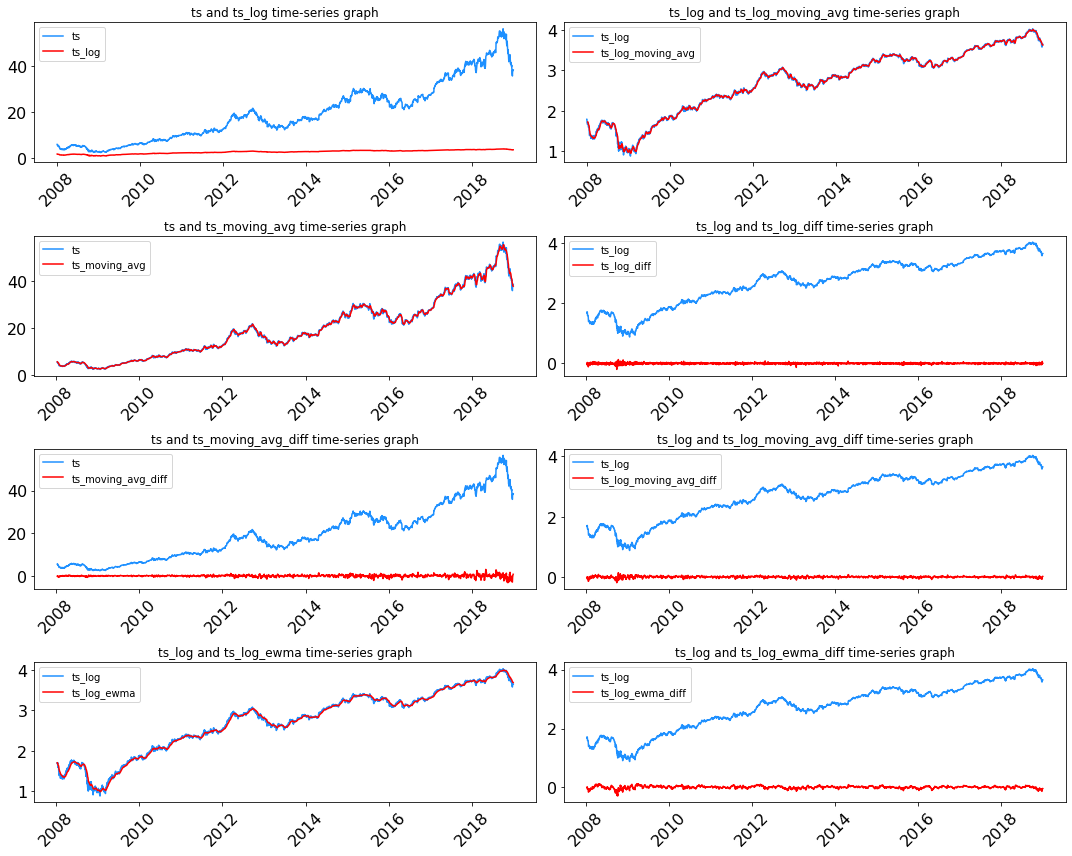

In [60]:
figure, axes = plt.subplots(nrows=4, ncols=2)

plot_transformed_data(df = df_tc, ts = 'ts', ts_transform = 'ts_log', axes = axes[0, 0])

plot_transformed_data(df = df_tc, ts = 'ts_log', ts_transform = 'ts_log_moving_avg', axes = axes[0, 1])


plot_transformed_data(df = df_tc_transform, ts = 'ts', ts_transform = 'ts_moving_avg', axes = axes[1, 0])


plot_transformed_data(df = df_tc_transform, ts = 'ts_log', ts_transform = 'ts_log_diff', axes = axes[1, 1])


plot_transformed_data(df = df_tc_transform, ts = 'ts', ts_transform = 'ts_moving_avg_diff', axes = axes[2, 0])


plot_transformed_data(df = df_tc_transform, ts = 'ts_log', ts_transform = 'ts_log_moving_avg_diff', axes = axes[2, 1])


plot_transformed_data(df = df_tc_transform, ts = 'ts_log', ts_transform = 'ts_log_ewma', axes = axes[3, 0])


plot_transformed_data(df = df_tc_transform, ts = 'ts_log', ts_transform = 'ts_log_ewma_diff', axes = axes[3, 1])


figure.tight_layout()

Let's perform the **ADH test** for above transformations 

In [61]:
def printmd(string):
    display(Markdown(string))
    
def plot_transformations(df, ts, axes):
    '''
    Plot transformed data with original time series data
    '''
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = axes.plot(df[ts], 
                    color = 'dodgerblue', 
                    label = 'Original')
    mean = axes.plot(rolmean, 
                    color = 'r', 
                    label = 'Rolling Mean')
    std = axes.plot(rolstd, 
                   color = 'dimgray', 
                   label = 'Rolling Std')
    axes.legend(loc = 'best')
    axes.set_title(f'Rolling Mean & Standard Deviation for {ts}')
    # Rotate x-labels
    axes.tick_params(axis = 'x', rotation = 45)
    

def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    printmd(f'**Results of Dickey-Fuller Test for {ts}:**')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

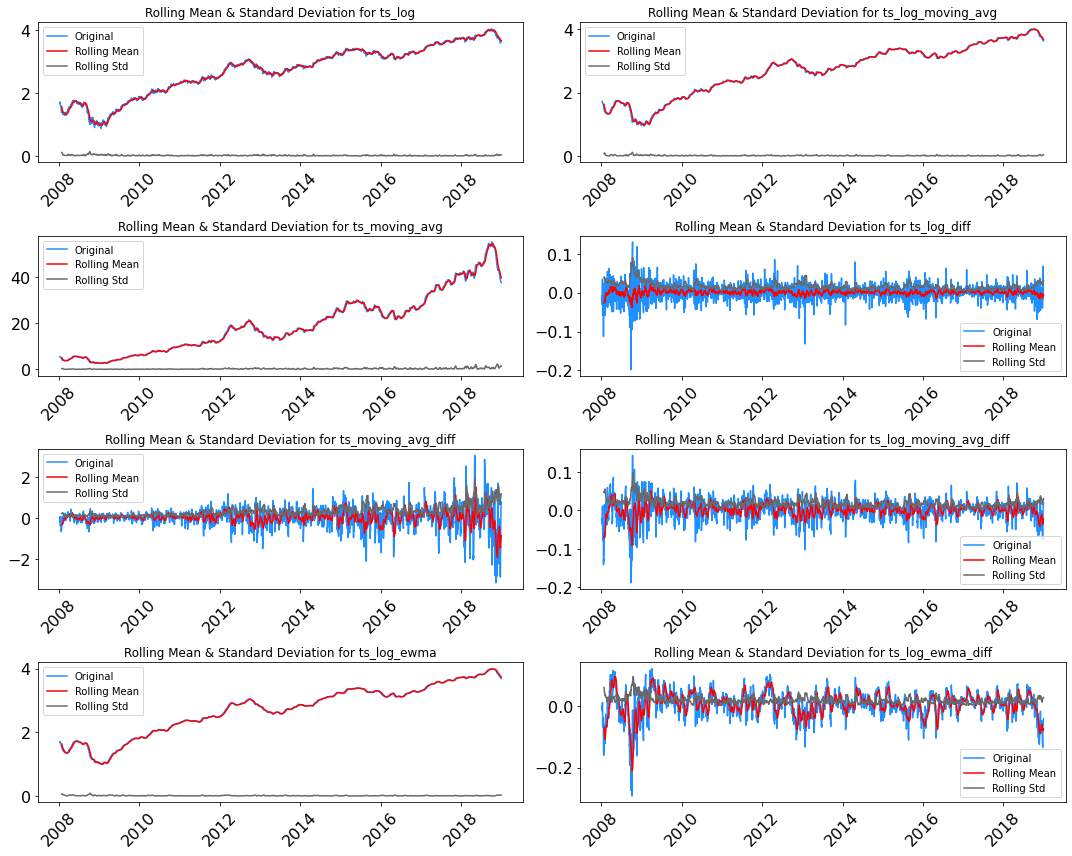

In [62]:
figure, axes = plt.subplots(nrows=4, ncols=2)

# Perform stationarity test
plot_transformations(df = df_tc_transform, 
                  ts = 'ts_log',
                  axes = axes[0, 0])

# Perform stationarity test
plot_transformations(df = df_tc_transform, 
                  ts = 'ts_log_moving_avg',
                  axes = axes[0, 1])

# Perform stationarity test
plot_transformations(df = df_tc_transform, 
                  ts = 'ts_moving_avg',
                  axes = axes[1, 0])

# Perform stationarity test
plot_transformations(df = df_tc_transform,
                  ts = 'ts_log_diff',
                  axes = axes[1, 1])

# Perform stationarity test
plot_transformations(df = df_tc_transform,
                  ts = 'ts_moving_avg_diff',
                  axes = axes[2, 0])

# Perform stationarity test
plot_transformations(df = df_tc_transform,
                  ts = 'ts_log_moving_avg_diff',
                  axes = axes[2, 1])

# Perform stationarity test
plot_transformations(df = df_tc_transform, 
                  ts = 'ts_log_ewma',
                  axes = axes[3, 0])

# Perform stationarity test
plot_transformations(df = df_tc_transform,
                  ts = 'ts_log_ewma_diff',
                  axes = axes[3, 1])

figure.tight_layout()

In [63]:
# Perform stationarity test
test_stationarity(df = df_tc_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_tc_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_tc_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_tc_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_tc_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_tc_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_tc_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_tc_transform,
                  ts = 'ts_log_ewma_diff')

**Results of Dickey-Fuller Test for ts_log:**

Test Statistic                   -1.297417
p-value                           0.630353
# Lags Used                      16.000000
Number of Observations Used    2746.000000
Critical Value (1%)              -3.432734
Critical Value (5%)              -2.862593
Critical Value (10%)             -2.567331
dtype: float64


**Results of Dickey-Fuller Test for ts_log_moving_avg:**

Test Statistic                   -1.415839
p-value                           0.574660
# Lags Used                      28.000000
Number of Observations Used    2734.000000
Critical Value (1%)              -3.432744
Critical Value (5%)              -2.862598
Critical Value (10%)             -2.567333
dtype: float64


**Results of Dickey-Fuller Test for ts_moving_avg:**

Test Statistic                   -0.632531
p-value                           0.863461
# Lags Used                      28.000000
Number of Observations Used    2734.000000
Critical Value (1%)              -3.432744
Critical Value (5%)              -2.862598
Critical Value (10%)             -2.567333
dtype: float64


**Results of Dickey-Fuller Test for ts_log_diff:**

Test Statistic                -1.213995e+01
p-value                        1.659854e-22
# Lags Used                    1.500000e+01
Number of Observations Used    2.747000e+03
Critical Value (1%)           -3.432733e+00
Critical Value (5%)           -2.862593e+00
Critical Value (10%)          -2.567330e+00
dtype: float64


**Results of Dickey-Fuller Test for ts_moving_avg_diff:**

Test Statistic                -8.495922e+00
p-value                        1.276029e-13
# Lags Used                    2.800000e+01
Number of Observations Used    2.734000e+03
Critical Value (1%)           -3.432744e+00
Critical Value (5%)           -2.862598e+00
Critical Value (10%)          -2.567333e+00
dtype: float64


**Results of Dickey-Fuller Test for ts_log_moving_avg_diff:**

Test Statistic                -1.109213e+01
p-value                        4.057351e-20
# Lags Used                    1.600000e+01
Number of Observations Used    2.746000e+03
Critical Value (1%)           -3.432734e+00
Critical Value (5%)           -2.862593e+00
Critical Value (10%)          -2.567331e+00
dtype: float64


**Results of Dickey-Fuller Test for ts_log_ewma:**

Test Statistic                   -1.402231
p-value                           0.581206
# Lags Used                      17.000000
Number of Observations Used    2745.000000
Critical Value (1%)              -3.432734
Critical Value (5%)              -2.862593
Critical Value (10%)             -2.567331
dtype: float64


**Results of Dickey-Fuller Test for ts_log_ewma_diff:**

Test Statistic                -7.995948e+00
p-value                        2.404124e-12
# Lags Used                    1.600000e+01
Number of Observations Used    2.746000e+03
Critical Value (1%)           -3.432734e+00
Critical Value (5%)           -2.862593e+00
Critical Value (10%)          -2.567331e+00
dtype: float64


Following transformed series are stationary at 95% confidence level

* Difference between logged ts and first-order difference logged ts
* Difference between ts and moving average ts
* Difference between logged ts and logged moving average ts
* Difference between logged ts and logged EWMA ts

Series of difference between logged ts and first-order difference logged ts has the smallest p-value and the most stationary series. Therefore we use that for predictions.

## Modelling: ARIMA

Let's plot autocorrelation and partial correlation plots to determine p and q vallues for ARIMA model

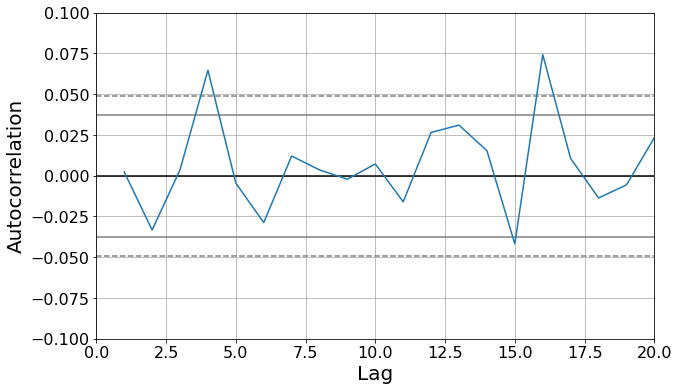

In [64]:
rcParams['figure.figsize'] = 10, 6
rcParams['axes.labelsize'] = 20
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16

autocorrelation_plot(df_tc_transform['ts_log_diff'])
plt.xlim(0,20)
plt.ylim(-0.10,0.10)
plt.show()

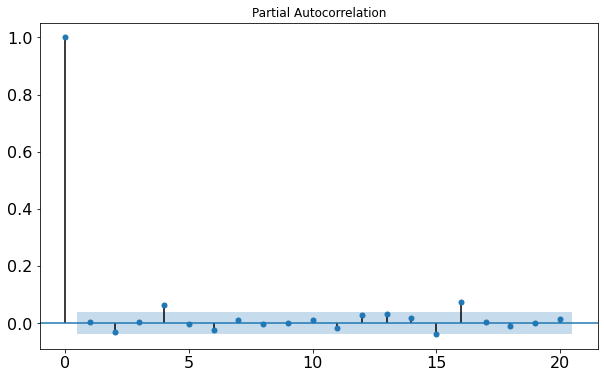

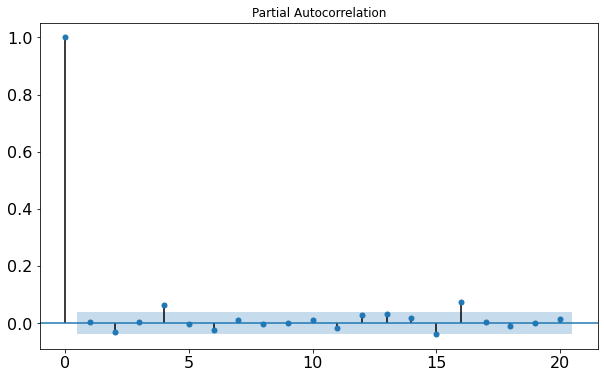

In [65]:
plot_pacf(df_tc_transform['ts_log_diff'], lags=20)

According to above plots we can determine,

* p = 4
* q = 1

Since we are using de-trended and de-seasonalized data, we can use **q = 0** to indicate not use Integrate component in ARIMA

Let's fit ARMA model with above values

In [66]:
def run_arima_model(df, ts, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima_model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[ts], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[ts][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[ts]))
  
  # plot fit
  plt.plot(df[ts], color = 'dodgerblue')
  plt.plot(results_.fittedvalues, color = 'r')
  plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))
  
  plt.show()
  plt.close()
  
  return results_

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



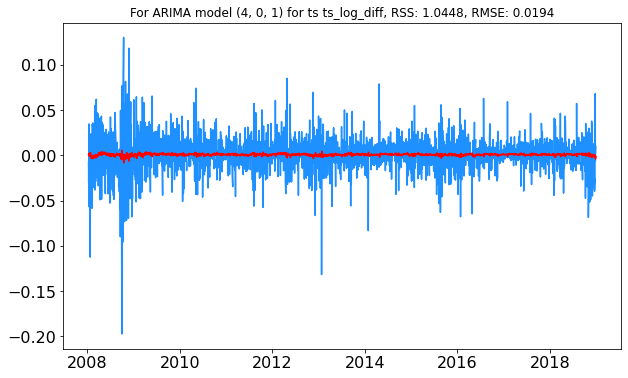

In [67]:
# ARMA model with 1st order differencing - ARMA (4,0,1)
model_MA = run_arima_model(df = df_tc_transform, 
                           ts = 'ts_log_diff', 
                           p = 4, 
                           d = 0, 
                           q = 1)

## Modelling: Prophet

In [68]:
model = Prophet()
train_df = df_f.rename(columns={"Adj Close":'y'})
train_df["ds"] = train_df['Date']
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


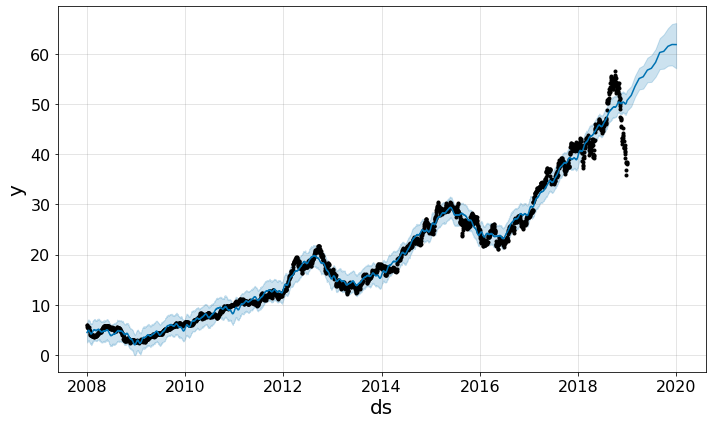

In [69]:
pd.plotting.register_matplotlib_converters()
future = model.make_future_dataframe(12, freq='M', include_history=True)
forecast = model.predict(future)
fig1 = model.plot(forecast)

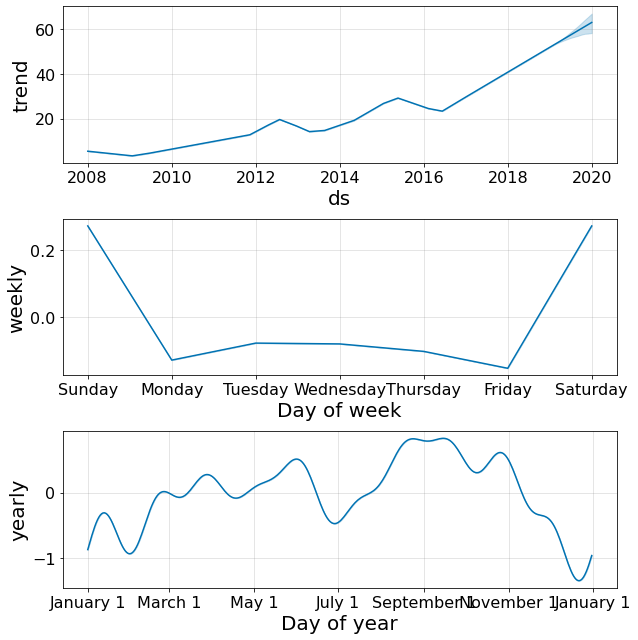

In [70]:
fig2 = model.plot_components(forecast)